Load required packages

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

plt.style.use('seaborn-white')
%matplotlib inline

Some plotting functions to help you plot the ROC curve

In [3]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + ' for house price > 200,000', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


Load the Sacramento housing data

In [6]:
sac = pd.read_csv('../assets/datasets/Sacramentorealestatetransactions.csv')

Create a binary variable where 1 indicates a house sold for over 200,000 and 0 indicates a house sold for equal to or less than 200,000.

Subset the data to just contain the number of beds, baths, the sq ft, and the over 200k indicator variable.

In [8]:
sac.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [9]:
sac['Price_Eval']=[1 if x > 200000 else 0 for x in sac['price'] ]

In [17]:
sac2=sac[['Price_Eval', 'beds', 'baths', 'sq__ft']]


Split your data into training and testing sets. The predictors are the beds, baths, and sq ft. The feature is the over 200k class variable. Make the test size 33% (and optionally stratify by the over 200k class).

In [20]:
sac2.dropna(inplace=True)
sac2['metrics']=sac2[['beds', 'baths', 'sq__ft']].sum(axis=1)


/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/samanthafalk/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
metrics= np.array(sac2.metrics.values)
metrics= metrics[:,np.newaxis]
X_train, X_test, Y_train, Y_test = train_test_split(metrics, sac2[['Price_Eval']].values, test_size=.33, stratify= sac2[['Price_Eval']].values, random_state=77)

In [23]:
logreg= LogisticRegression(random_state=77)
logreg.fit(X_train, Y_train)
y_pred= logreg.predict(X_test)

/Users/samanthafalk/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fit a logistic regression on the training data.

Print out the confusion matrix

In [25]:
conmat = np.array(confusion_matrix(Y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['over_200k', 'under_200k'],columns=['predicted_over_200k','predicted_under_200k'])

print(confusion)

            predicted_over_200k  predicted_under_200k
over_200k                   143                    35
under_200k                  109                    39


Calculate the accuracy, precision, and recall. What can these three metrics tell you about your model?

In [30]:
acc= accuracy_score(Y_test, y_pred)
acc

0.55828220858895705

In [29]:
print (classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.53      0.26      0.35       148
          1       0.57      0.80      0.67       178

avg / total       0.55      0.56      0.52       326



Say as a real estate agent, I prioritize minimizing false positives (predicting a house will sell for over 200k when it actually sells for under) because false positives make me lose money.

Change the decision threshold to **lower the false positive rate** and then print out the new confusion matrix. What is the downside to lowering the false positive rate?

In [45]:
y_pp= pd.DataFrame(logreg.predict_proba(X_test),
                  columns= ['under_200k', 'over_200k'])
y_pp['pred_cost_tresh10'] = [1 if x >= 0.1 else 0 for x in y_pp.over_200k.values]
print(y_pp.iloc[0:10])

   under_200k  over_200k  pred_cost_tresh10
0    0.432892   0.567108                  1
1    0.501289   0.498711                  1
2    0.441754   0.558246                  1
3    0.660230   0.339770                  1
4    0.659009   0.340991                  1
5    0.466005   0.533995                  1
6    0.419597   0.580403                  1
7    0.660230   0.339770                  1
8    0.494324   0.505676                  1
9    0.449812   0.550188                  1


In [46]:
conmat_10 = np.array(confusion_matrix(Y_test, y_pp.pred_cost_tresh10.values, labels=[1,0]))
conmat_10

confusion_10 = pd.DataFrame(conmat_10, index=['over_200k', 'under_200k'],columns=['predicted_over_200k','predicted_under_200k'])


print(confusion_10)

            predicted_over_200k  predicted_under_200k
over_200k                   178                     0
under_200k                  148                     0


Plot the ROC curve using the plotting function provided.

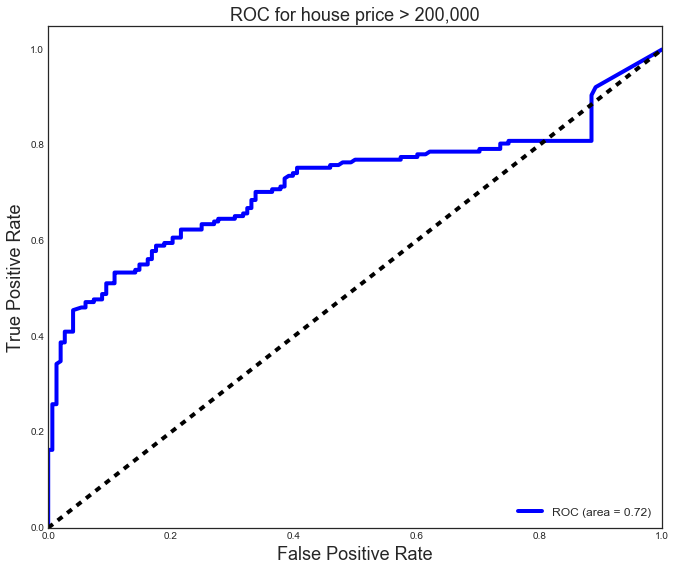

In [47]:
Y_score = logreg.decision_function(X_test)
plot_roc(Y_test, Y_score)

Bonus: when might precision and recall be more useful than the ROC?

Precision and recall are more useful when the proportion of the positive class is smaller, since they are sensitive to this.